In [22]:
# Dependencies
%pylab inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import matplotlib.ticker as mtick
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Read In Data

In [23]:
filePath = "./Data/h1b_kaggle.csv"
df = pd.read_csv(filePath, header=0)

#### Drop unnecessary features

## Data Cleaning
+ Remove outliers 
+ Remove missing data

In [24]:
# Drop unnecessary features
try:
    df.drop(['Unnamed: 0', 'lon', 'lat', 'SOC_NAME'], axis=1, inplace=True)
except ValueError:
    print("Already deleted unnecessary features")
original_number_of_instances = len(df)

#### Drop instances with missing feature values

In [25]:
df.dropna(inplace=True)

In [26]:
instances_after_missing_dropped = len(df)
print("Before deletion: {} After Deletion : {} "
      .format(original_number_of_instances, instances_after_missing_dropped))

Before deletion: 3002458 After Deletion : 3002311 


#### Remove Outliers in the ___PREVAILING_WAGE___ feature
#### Change ___PREVAILING_WAGE___ values to _int_
#### Change ___YEAR___ values to _int_

In [27]:
# Remove outliers in wage
df2 = df[~(np.abs(df["PREVAILING_WAGE"] - df["PREVAILING_WAGE"].mean()) > (2 * df["PREVAILING_WAGE"].std()))]
def transform_to_int(x):
    return int(x)

df2['PREVAILING_WAGE'] = df2["PREVAILING_WAGE"].apply(transform_to_int)
df2['YEAR'] = df2["YEAR"].apply(transform_to_int)


#### Limit the outcomes in the target to :
+ CERTIFIED | CERTIFIED-WITHDRAWN | DENIED | WITHDRAWN

In [28]:
certified = df["CASE_STATUS"] == "CERTIFIED"
certified_withdrawn = df["CASE_STATUS"] == "CERTIFIED-WITHDRAWN"
denied = df["CASE_STATUS"] == "DENIED"
withdrawn = df["CASE_STATUS"] == "WITHDRAWN"

df2 = df2[certified | certified_withdrawn | denied | withdrawn]

#### Select 20,000 instances to sample. Using Sampling without replacement method of sampling

In [52]:
# df.take() uses positions to select instances
df3 = df2.take(np.random.permutation(len(df2)))[:20000]

In [53]:
len(df3)

20000

## Data Understanding and Description

## Data Preprocessing

In [54]:
df3[:5]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
1515954,CERTIFIED,NLT CORPORATION,ORACLE APPLICATIONS ANALYST,Y,82930,2014,"SPRINGFIELD, VIRGINIA"
1441891,DENIED,"ORACLE AMERICA, INC.",SOFTWARE DEVELOPER,Y,96164,2014,"WASHINGTON, DISTRICT OF COLUMBIA"
2645167,CERTIFIED,PURDUE UNIVERSITY,POST DOCTORAL RESEARCH ASSOCIATE,Y,38522,2011,"WEST LAFAYETTE, INDIANA"
384363,CERTIFIED,CAPGEMINI AMERICA INC,SOFTWARE ENGINEER 2,Y,74797,2016,"CLARKS SUMMIT, PENNSYLVANIA"
2231381,CERTIFIED-WITHDRAWN,"INTEGRATED RESOURCES, INC.",PHYSICAL THERAPIST,Y,58073,2012,"SOUTH BELOIT, ILLINOIS"


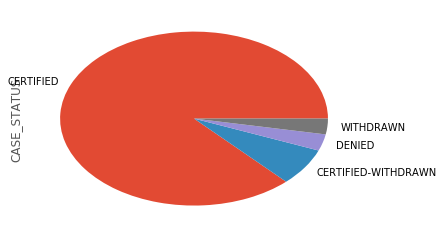

In [55]:
df3["CASE_STATUS"].value_counts().plot.pie()

### Encode the independent features

In [56]:
cols_list = list(df3.columns)
s = " + ".join([item for item in cols_list if item != "CASE_STATUS"])
print(s)

EMPLOYER_NAME + JOB_TITLE + FULL_TIME_POSITION + PREVAILING_WAGE + YEAR + WORKSITE


### Encode the Data

In [57]:
X = df3[["EMPLOYER_NAME", "JOB_TITLE", "FULL_TIME_POSITION", "PREVAILING_WAGE", "YEAR", "WORKSITE"]]
y = df3["CASE_STATUS"]

In [58]:

X['PREVAILING_WAGE'] = X["PREVAILING_WAGE"].apply(transform_to_int)
X['YEAR'] = X["YEAR"].apply(transform_to_int)
X.head()

,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
1515954,NLT CORPORATION,ORACLE APPLICATIONS ANALYST,Y,82930,2014,"SPRINGFIELD, VIRGINIA"
1441891,"ORACLE AMERICA, INC.",SOFTWARE DEVELOPER,Y,96164,2014,"WASHINGTON, DISTRICT OF COLUMBIA"
2645167,PURDUE UNIVERSITY,POST DOCTORAL RESEARCH ASSOCIATE,Y,38522,2011,"WEST LAFAYETTE, INDIANA"
384363,CAPGEMINI AMERICA INC,SOFTWARE ENGINEER 2,Y,74797,2016,"CLARKS SUMMIT, PENNSYLVANIA"
2231381,"INTEGRATED RESOURCES, INC.",PHYSICAL THERAPIST,Y,58073,2012,"SOUTH BELOIT, ILLINOIS"


In [59]:
X.dtypes

EMPLOYER_NAME         object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE        int64
YEAR                   int64
WORKSITE              object
dtype: object

In [60]:
import patsy 

In [116]:
X_enc = patsy.dmatrix(s, X, return_type='dataframe')

In [62]:
len(X_enc)

20000

#### Now need to split the data that has been encoded

In [63]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss

StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2,
            train_size=None)

In [66]:
X_enc_vals = X_enc.values
y_vals = y.values

In [67]:
for train_index, test_index in sss.split(X_enc_vals, y_vals):
    X_train, X_test = X_enc_vals[train_index], X_enc_vals[test_index]
    y_train, y_test = y_vals[train_index], y_vals[test_index]

In [75]:
len(X_train)

16000

In [71]:
len(y_train)

16000

In [72]:
len(X_test)

4000

In [73]:
len(y_test)

4000

## Train K-nearest Neighbours Classifier

In [76]:
neigh = KNeighborsClassifier(n_neighbors=3)
k_nearest_cls = neigh.fit(X_train, y_train)

In [77]:
predicted = neigh.predict(X_test)

## Evaluation of Classifier

In [78]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

#### Classification Report

In [119]:
y_true = y_test[:]
y_pred = predicted[:]
print(classification_report(y_true, y_pred))

                     precision    recall  f1-score   support

          CERTIFIED       0.87      0.97      0.92      3483
CERTIFIED-WITHDRAWN       0.08      0.02      0.03       278
             DENIED       0.17      0.03      0.05       123
          WITHDRAWN       0.00      0.00      0.00       116

        avg / total       0.77      0.85      0.81      4000



#### Accuracy Score
___

In [81]:
print("Normalized Accuracy Score : {:.3f} ".format(accuracy_score(y_true, y_pred)))
print("Correctly Classified {:d} out of {} instance".format(accuracy_score(y_true, 
                                                                           y_pred, 
                                                                           normalize=False), 
                                                                           len(y_test)))

Normalized Accuracy Score : 0.851 
Correctly Classified 3404 out of 4000 instance


#### Precision Score
___
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
The best value is 1 and the worst value is 0.

+ The precision Value returned is the weighted average of the precision of each class for the multiclass task.

In [94]:
# micro - Calculate metrics globally by counting the total true positives, false negatives and false positives.
# weighted - Calculate metrics for each label, and find their average, weighted by support 
#            (the number of true instances for each label). This alters ‘macro’ to account for label 
#            imbalance; it can result in an F-score that is not between precision and recall
classifier_p_score_w = precision_score(y_true, y_pred, average='weighted')
print("Precision Value averaged by 'weighted' is {:.2f}".format(classifier_p_score_w))

classifier_p_score_mi = precision_score(y_true, y_pred, average='micro')
print("Precision Value averaged by 'micro' is {:.2f}".format(classifier_p_score_mi))

Precision Value averaged by 'weighted' is 0.77
Precision Value averaged by 'micro' is 0.85


In [93]:
# macro - Calculate metrics for each label, and find their unweighted mean. 
#         This does not take label imbalance into account.
classifier_p_score_ma = precision_score(y_true, y_pred, average='macro')
print("Precision Value averaged by 'macro' is {:.2f}".format(classifier_p_score_ma))

Precision Value averaged by 'macro' is 0.28


+ This is significantly less than the other two measure because the metrics are calculated for each label and this classifier. Perfoms poorly on classifying denied and withdrawn instances but perfoms well on classifying certified outcomes

#### Recall Score

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
The best value is 1 and the worst value is 0.

In [96]:
classifier_r_score_w = recall_score(y_true, y_pred, average='weighted')
classifier_r_score_ma = recall_score(y_true, y_pred, average='macro')
classifier_r_score_mi = recall_score(y_true, y_pred, average='micro')
print("Recall Value averaged by 'weighted' is {:.2f}".format(classifier_r_score_w))
print("Recall Value averaged by 'macro' is {:.2f}".format(classifier_r_score_ma))
print("Recall Value averaged by 'micro' is {:.2f}".format(classifier_r_score_mi))

Recall Value averaged by 'weighted' is 0.85
Recall Value averaged by 'macro' is 0.26
Recall Value averaged by 'micro' is 0.85


#### Confusion Matrix

In [97]:
confusion_matrix(y_true, y_pred)

array([[3394,   65,   18,    6],
       [ 269,    6,    1,    2],
       [ 118,    1,    4,    0],
       [ 111,    4,    1,    0]])

In [102]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [114]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
class_names = ['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', "WITHDRAWN"]

Confusion matrix, without normalization
[[3394   65   18    6]
 [ 269    6    1    2]
 [ 118    1    4    0]
 [ 111    4    1    0]]


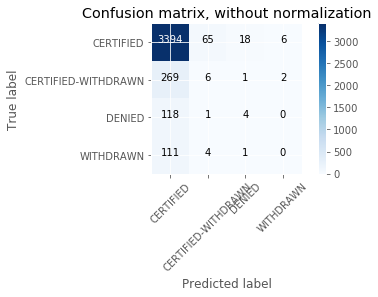

In [115]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions

We see that apart from CERTIFIED all other labels were poorly predicted with the WITHDRAWN lable totally miss classifed

The Vertical column values for CERTIFIED-WITHDRAWN, DENIED, WITHDRAWN reflect (FP) - actually negative outcomes wrongly predicted as positive. Whereby CERTIFIED is a positive outcome

The horizontal row for CERTIFIED reflects (FN) - Positive outcomes, wrongly predicted as negative, where anything but CERTIFIED is a negative outcome

Normalized confusion matrix
[[ 0.97  0.02  0.01  0.  ]
 [ 0.97  0.02  0.    0.01]
 [ 0.96  0.01  0.03  0.  ]
 [ 0.96  0.03  0.01  0.  ]]


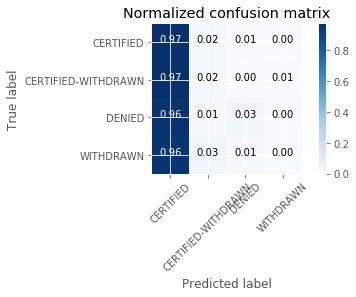

In [107]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ROC Curve

In [121]:
y_score = k_nearest_cls.predict_proba(X_test)

In [123]:
fpr, tpr, thresholds = roc_curve(y_true, y_score[:,1], pos_label='CERTIFIED')


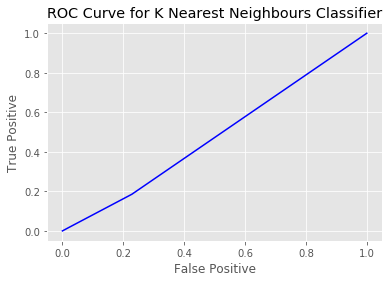

In [125]:
plt.plot(fpr, tpr, 'b-')
plt.title("ROC Curve for K Nearest Neighbours Classifier")
plt.ylabel("True Positive")
plt.xlabel("False Positive")
plt.show()

### Precision Recall Curve

In [127]:
precision, recall, threshold = precision_recall_curve(y_true, y_score[:,1], pos_label='CERTIFIED')

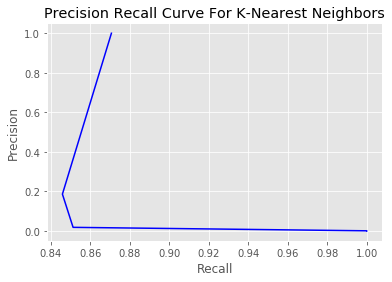

In [129]:
plt.plot(precision, recall, 'b-')
plt.title("Precision Recall Curve For K-Nearest Neighbors")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

### K nearest Neighbour classification with more neighbours

In [134]:
neigh2 = KNeighborsClassifier(n_neighbors=7)
k_nearest_cls2 = neigh2.fit(X_train, y_train)
predicted2 = neigh2.predict(X_test)

In [135]:
y_true = y_test[:]
y_pred = predicted2[:]
print(classification_report(y_true, y_pred))

                     precision    recall  f1-score   support

          CERTIFIED       0.87      1.00      0.93      3483
CERTIFIED-WITHDRAWN       0.00      0.00      0.00       278
             DENIED       0.50      0.02      0.03       123
          WITHDRAWN       0.00      0.00      0.00       116

        avg / total       0.77      0.87      0.81      4000



+ Increasing the number of neighbours used by the classifier gives us relatively the same Evaluation  
** Possible ways to improve the performance of this classifier **
---
I think the performance is poor when it comes to classifing instances as anything but CERTIFIED. A significant number of instances used in training have a the label CERTIFIED so the model might be overfit towards this outcome
___
Another reason that K Nearest Neighbour's might not perform well in this case could be the presence of outliers. Specifically in the prevailing wage feature. I handled this in data cleaning but there is no way of removing most of them without eliminating a significant number of instances

CERTIFIED              13931
CERTIFIED-WITHDRAWN     1111
DENIED                   491
WITHDRAWN                467
dtype: int64


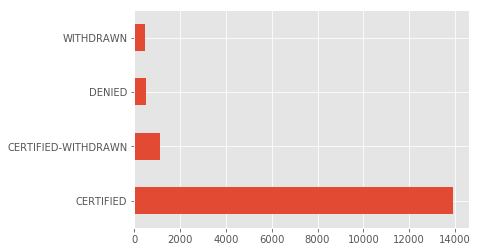

In [146]:
# Distribution of labels in the training set
y_train_series = pd.Series(y_train)
print(y_train_series.value_counts())
y_train_series.value_counts().plot.barh()